In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, jaccard_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from skimage.feature import graycomatrix, graycoprops

def prepare_dataset(root_folder):
    feature_list = []
    target_labels = []
    
    if os.path.exists(root_folder):
        for class_name in os.listdir(root_folder):
            class_dir = os.path.join(root_folder, class_name)
            if os.path.isdir(class_dir):
                for fname in os.listdir(class_dir):
                    fpath = os.path.join(class_dir, fname)
                    img_gray = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                    if img_gray is not None:
                        try:
                            feats = get_hist_features(img_gray)
                            feature_list.append(feats)
                            target_labels.append(class_name)
                        except NameError:
                            pass
                            
    return np.array(feature_list), np.array(target_labels)

# Признаки Гистограммы

Данные загружены. Образцов: 810, Классов: 10


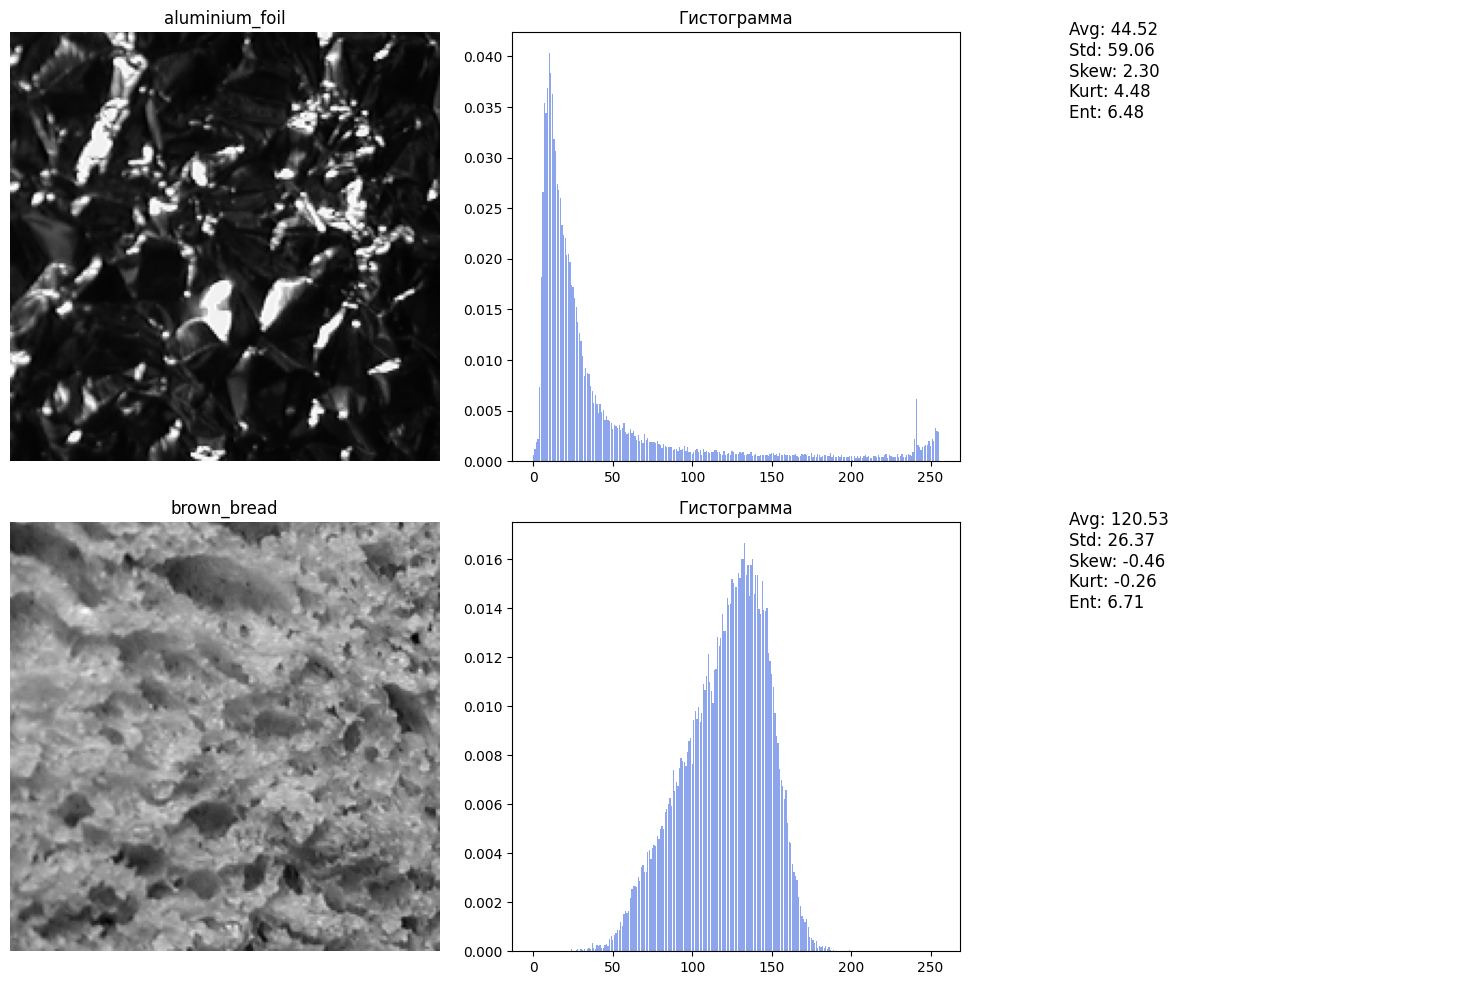

In [9]:
def calc_stat_metrics(image, n_bins=256):
    raw_hist = cv2.calcHist([image], [0], None, [n_bins], [0, 256])
    raw_hist = raw_hist.flatten()
    hist_norm = raw_hist / raw_hist.sum()
    
    brightness_vals = np.arange(n_bins)
    stats_out = {}

    mean_val = np.sum(hist_norm * brightness_vals)
    stats_out['avg'] = mean_val

    var_val = np.sum(hist_norm * (brightness_vals - mean_val)**2)
    std_val = np.sqrt(var_val)
    stats_out['std'] = std_val

    if std_val > 0:
        skew_val = np.sum(hist_norm * ((brightness_vals - mean_val) / std_val)**3)
    else:
        skew_val = 0
    stats_out['skew'] = skew_val

    if std_val > 0:
        kurt_val = np.sum(hist_norm * ((brightness_vals - mean_val) / std_val)**4) - 3
    else:
        kurt_val = -3
    stats_out['kurt'] = kurt_val

    valid_probs = hist_norm[hist_norm > 0]
    entropy_val = -np.sum(valid_probs * np.log2(valid_probs))
    stats_out['entropy'] = entropy_val
    
    cumul_sum = np.cumsum(hist_norm)
    stats_out['p25'] = np.argmax(cumul_sum >= 0.25)
    stats_out['p50'] = np.argmax(cumul_sum >= 0.50)
    stats_out['p75'] = np.argmax(cumul_sum >= 0.75)

    nonzero_indices = np.where(raw_hist > 0)[0]
    if len(nonzero_indices) > 0:
        stats_out['min_v'] = nonzero_indices[0]
        stats_out['max_v'] = nonzero_indices[-1]
    else:
        stats_out['min_v'] = 0
        stats_out['max_v'] = 255
        
    return stats_out, hist_norm

def get_hist_features(img, n_bins=256):
    metrics, _ = calc_stat_metrics(img, n_bins)
    feature_vector = [
        metrics['avg'],
        metrics['std'],
        metrics['skew'],
        metrics['kurt'],
        metrics['entropy'],
        metrics['p25'],
        metrics['p50'],
        metrics['p75'],
        metrics['min_v'],
        metrics['max_v']
    ]
    return np.array(feature_vector)

DATASET_DIR = "KTH_TIPS"

X_dummy, y_dummy = prepare_dataset(DATASET_DIR)
print(f"Данные загружены. Образцов: {X_dummy.shape[0]}, Классов: {X_dummy.shape[1] if X_dummy.ndim > 1 else 0}")


def show_hist_demo(root_dir, count=2):
    classes = os.listdir(root_dir)
    fig, ax = plt.subplots(count, 3, figsize=(15, 5*count))
    
    for i in range(min(count, len(classes))):
        c_name = classes[i]
        c_path = os.path.join(root_dir, c_name)
        f_name = os.listdir(c_path)[3]
        
        full_p = os.path.join(c_path, f_name)
        img = cv2.imread(full_p, cv2.IMREAD_GRAYSCALE)
        
        s, h = calc_stat_metrics(img)

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 0].set_title(c_name)
        ax[i, 0].axis('off')

        ax[i, 1].bar(range(256), h, color='royalblue', alpha=0.6)
        ax[i, 1].set_title('Гистограмма')

        txt = (f"Avg: {s['avg']:.2f}\nStd: {s['std']:.2f}\n"
               f"Skew: {s['skew']:.2f}\nKurt: {s['kurt']:.2f}\n"
               f"Ent: {s['entropy']:.2f}")
        ax[i, 2].text(0.1, 0.8, txt, transform=ax[i, 2].transAxes, fontsize=12)
        ax[i, 2].axis('off')
        
    plt.tight_layout()
    plt.show()

if os.path.exists(DATASET_DIR):
    show_hist_demo(DATASET_DIR)

# Признаки Фильтров Laws

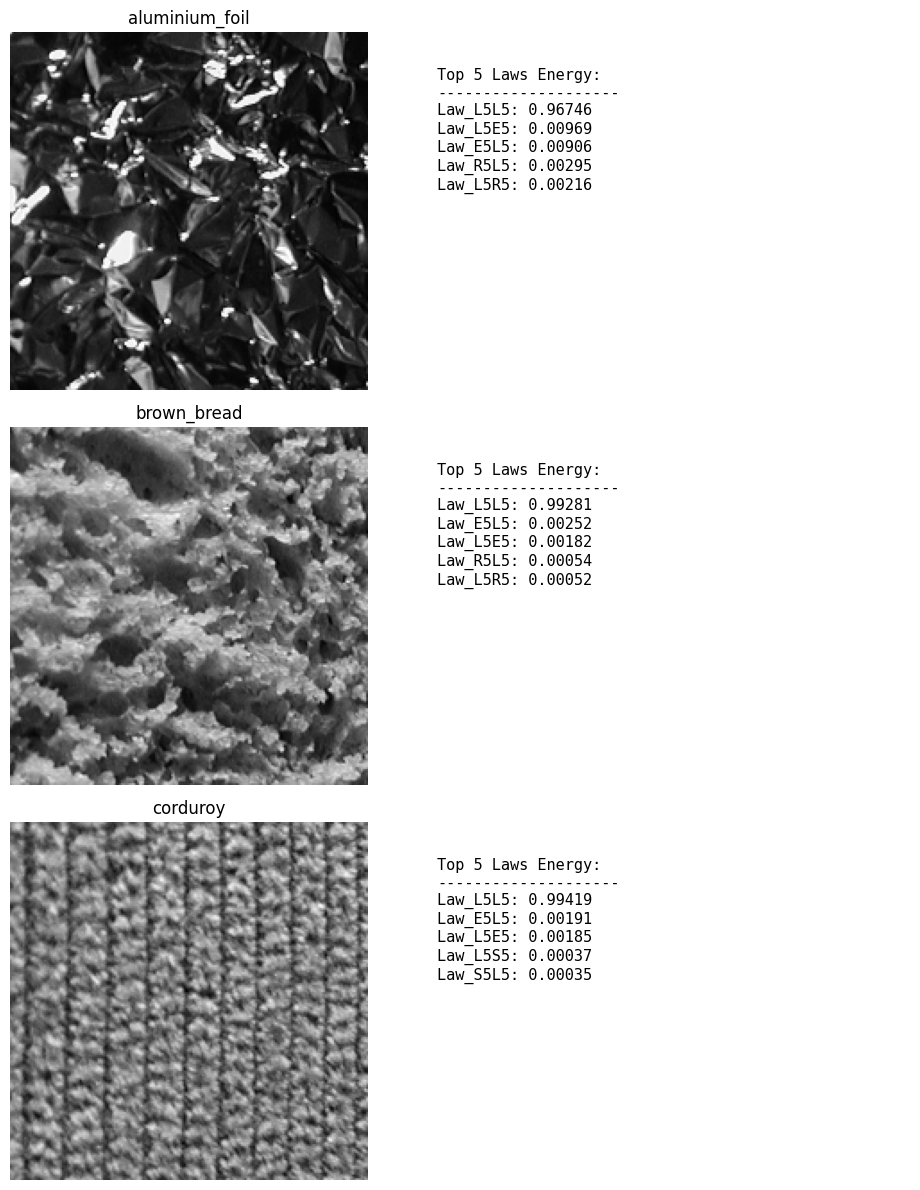

In [10]:
def extract_laws_energy(img_input, normalize=True):
    vec_l5 = np.array([1, 4, 6, 4, 1])
    vec_e5 = np.array([-1, -2, 0, 2, 1])
    vec_s5 = np.array([-1, 0, 2, 0, -1])
    vec_w5 = np.array([-1, 2, 0, -2, 1])
    vec_r5 = np.array([1, -4, 6, -4, 1])
    vectors = [vec_l5, vec_e5, vec_s5, vec_w5, vec_r5]
    v_names = ['L5', 'E5', 'S5', 'W5', 'R5']
    kernels_2d = []
    k_names = []
    for i, v1 in enumerate(vectors):
        for j, v2 in enumerate(vectors):
            k = np.outer(v1, v2)
            kernels_2d.append(k)
            k_names.append(f"{v_names[i]}{v_names[j]}")    
    feats_vals = []
    feats_lbls = []
    for kern, name in zip(kernels_2d, k_names):
        conv_res = cv2.filter2D(img_input.astype(np.float32), -1, kern)
        energy = np.mean(conv_res ** 2)
        
        feats_vals.append(energy)
        feats_lbls.append(f"Law_{name}")
    feats_vals = np.array(feats_vals)
    if normalize:
        s = np.sum(feats_vals)
        if s > 0:
            feats_vals /= s
            
    return feats_vals, feats_lbls

def show_laws_demo(root_dir, samples=3):
    folders = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    fig, ax = plt.subplots(samples, 2, figsize=(10, 4*samples))
    
    for i in range(min(samples, len(folders))):
        c_name = folders[i]
        path = os.path.join(root_dir, c_name)
        f_img = os.listdir(path)[5]
        
        img = cv2.imread(os.path.join(path, f_img), cv2.IMREAD_GRAYSCALE)
        vals, names = extract_laws_energy(img)
        idx_sorted = np.argsort(vals)[::-1][:5]
        
        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 0].set_title(f"{c_name}")
        ax[i, 0].axis('off')
        
        txt_res = "Top 5 Laws Energy:\n" + "-"*20 + "\n"
        for idx in idx_sorted:
            txt_res += f"{names[idx]}: {vals[idx]:.5f}\n"
            
        ax[i, 1].text(0.05, 0.9, txt_res, transform=ax[i, 1].transAxes, family='monospace', fontsize=11, va='top')
        ax[i, 1].axis('off')
        
    plt.tight_layout()
    plt.show()

if os.path.exists(DATASET_DIR):
    show_laws_demo(DATASET_DIR)

# Признаки GLCM

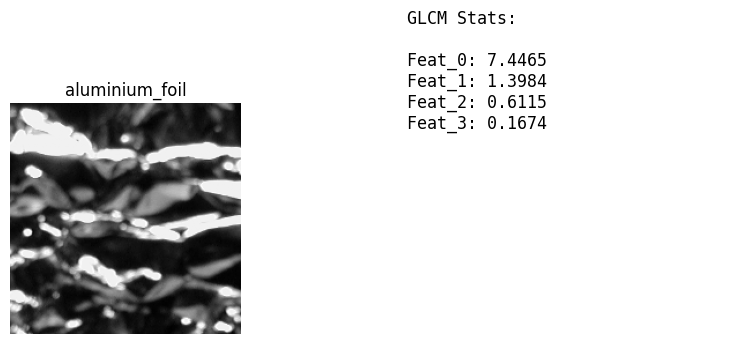

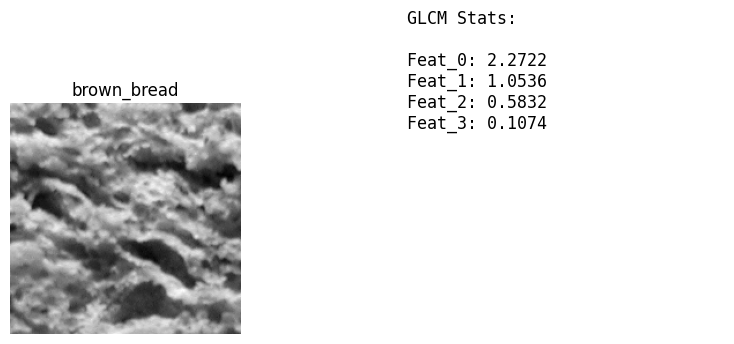

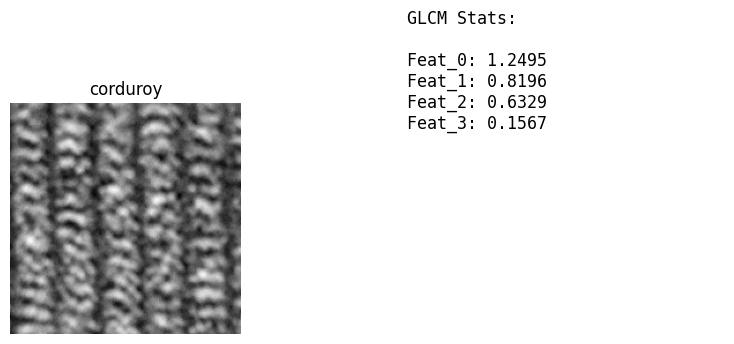

In [11]:
def get_glcm_stats(img, dists=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    img_quant = (img // 8).astype(np.uint8)
    
    glcm_mat = graycomatrix(img_quant, distances=dists, angles=angles, 
                            levels=32, symmetric=True, normed=True)
    props_to_calc = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    feat_vec = []
    
    for p in props_to_calc:
        val = np.mean(graycoprops(glcm_mat, p))
        feat_vec.append(val)
        
    return np.array(feat_vec)

def show_glcm_demo(root_dir, n=3):
    folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
    
    for i in range(min(n, len(folders))):
        name = folders[i]
        p = os.path.join(root_dir, name)
        files = os.listdir(p)
        
        if len(files) > 2:
            img = cv2.imread(os.path.join(p, files[2]), cv2.IMREAD_GRAYSCALE)
            
            f_vals = get_glcm_stats(img)
            
            plt.figure(figsize=(10, 3))
            plt.subplot(1, 2, 1)
            plt.imshow(img, cmap='gray')
            plt.title(name)
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            lbls = ['Contrast', 'Homogen', 'Energy', 'Entropy (sim)']
            txt = "GLCM Stats:\n\n"
            for j in range(4): 
                if j < len(f_vals):
                    txt += f"Feat_{j}: {f_vals[j]:.4f}\n"
            
            plt.text(0.1, 0.8, txt, transform=plt.gca().transAxes, family='monospace', fontsize=12)
            plt.axis('off')
            plt.show()

if os.path.exists(DATASET_DIR):
    show_glcm_demo(DATASET_DIR)

# Сборка и Обучение Моделей

In [12]:
all_img_paths = []
if os.path.exists(DATASET_DIR):
    for fldr in os.listdir(DATASET_DIR):
        full_d = os.path.join(DATASET_DIR, fldr)
        if os.path.isdir(full_d):
            for f in os.listdir(full_d):
                if f.lower().endswith(('.png', '.jpg')):
                    all_img_paths.append(os.path.join(full_d, f))

print(f"Всего изображений для обучения: {len(all_img_paths)}")

data_hist, data_laws, data_glcm = [], [], []
labels_raw = []

for idx, p in enumerate(all_img_paths):
    im = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if im is None: continue
    im = cv2.resize(im, (128, 128), interpolation=cv2.INTER_AREA)
    data_hist.append(get_hist_features(im))
    l_feat, _ = extract_laws_energy(im)
    data_laws.append(l_feat)
    data_glcm.append(get_glcm_stats(im))
    labels_raw.append(os.path.basename(os.path.dirname(p)))

X_dict = {
    'HIST': np.array(data_hist),
    'LAWS': np.array(data_laws),
    'GLCM': np.array(data_glcm)
}
y_vec = np.array(labels_raw)
print(f"Размерность HIST: {X_dict['HIST'].shape}")
print(f"Классов: {len(np.unique(y_vec))}")
enc = LabelEncoder()
y_enc = enc.fit_transform(y_vec)

zoo_models = {
    'KNN': KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
    'SVM': SVC(kernel='rbf', random_state=123),
    'Tree': DecisionTreeClassifier(max_depth=10, random_state=123)
}
trained_wrappers = {}
for key, X_data in X_dict.items():
    print(f"\n>>> Обучение на признаках: {key}")
    X_tr, X_ts, y_tr, y_ts = train_test_split(X_data, y_enc, test_size=0.25, random_state=42, stratify=y_enc)
    scl = StandardScaler()
    X_tr_sc = scl.fit_transform(X_tr)
    X_ts_sc = scl.transform(X_ts)
    
    curr_method_models = {}
    
    for m_name, m_proto in zoo_models.items():
        if m_name == 'KNN': clf = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
        elif m_name == 'SVM': clf = SVC(kernel='rbf', random_state=123)
        else: clf = DecisionTreeClassifier(max_depth=10, random_state=123)

        if m_name == 'SVM' or m_name == 'KNN':
            clf.fit(X_tr_sc, y_tr)
            preds = clf.predict(X_ts_sc)
            curr_method_models[m_name] = (clf, scl)
        else:
            clf.fit(X_tr, y_tr)
            preds = clf.predict(X_ts)
            curr_method_models[m_name] = clf
            
        print(f"[{m_name}] Report:")
        print(f"   Accuracy: {accuracy_score(y_ts, preds):.3f}")
        
    trained_wrappers[key] = curr_method_models

print("\nВсе классификаторы обучены.")

Всего изображений для обучения: 810
Размерность HIST: (810, 10)
Классов: 10

>>> Обучение на признаках: HIST
[KNN] Report:
   Accuracy: 0.837
[SVM] Report:
   Accuracy: 0.837
[Tree] Report:
   Accuracy: 0.842

>>> Обучение на признаках: LAWS
[KNN] Report:
   Accuracy: 0.813
[SVM] Report:
   Accuracy: 0.576
[Tree] Report:
   Accuracy: 0.690

>>> Обучение на признаках: GLCM
[KNN] Report:
   Accuracy: 0.621
[SVM] Report:
   Accuracy: 0.552
[Tree] Report:
   Accuracy: 0.517

Все классификаторы обучены.


# Сегментация

Сегментация методом: Hist_KNN...
[HIST-KNN] Итоговые классы на маске: [0 1 2 3]
Сегментация методом: Laws_SVM...
[LAWS-SVM] Итоговые классы на маске: [0 1 2 3]
Сегментация методом: Laws_Tree...
[LAWS-Tree] Итоговые классы на маске: [0 1 2 3]


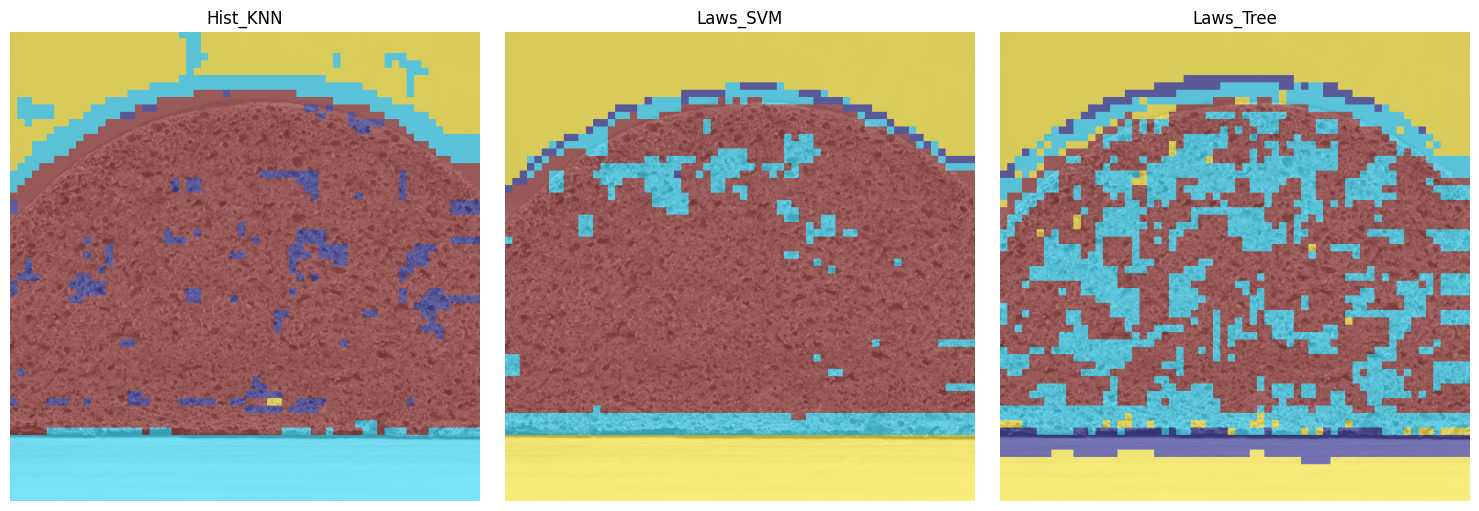

In [13]:
def apply_sliding_window(model_container, feat_type, model_type, img_path, 
                         win_size=32, stride=16, keep_top_k=4):
    
    src_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if src_img is None:
        return None
    
    H, W = src_img.shape
    prediction_map = np.zeros((H, W), dtype=np.uint8)
    
    preds_list = []
    stored_obj = model_container[feat_type][model_type]
    
    if isinstance(stored_obj, tuple):
        clf, scaler = stored_obj
        has_scaler = True
    else:
        clf = stored_obj
        has_scaler = False
    for r in range(0, H - win_size + 1, stride):
        for c in range(0, W - win_size + 1, stride):
            patch = src_img[r:r+win_size, c:c+win_size]
            
            if feat_type == 'HIST':
                f_vec = get_hist_features(patch)
            elif feat_type == 'LAWS':
                f_vec, _ = extract_laws_energy(patch)
            elif feat_type == 'GLCM':
                f_vec = get_glcm_stats(patch)

            f_vec = f_vec.reshape(1, -1)
            if has_scaler:
                f_vec = scaler.transform(f_vec)
                
            cls_res = clf.predict(f_vec)[0]

            prediction_map[r:r+win_size, c:c+win_size] = cls_res
            preds_list.append(cls_res)
    vals, counts = np.unique(preds_list, return_counts=True)
    top_indices = np.argsort(counts)[-keep_top_k:]
    top_classes = vals[top_indices]
    
    cleaned_map = np.zeros_like(prediction_map)
    for new_id, real_id in enumerate(top_classes):
        cleaned_map[prediction_map == real_id] = new_id
    mask_noise = ~np.isin(prediction_map, top_classes)
    if np.any(mask_noise):
        cleaned_map[mask_noise] = 1
        
    print(f"[{feat_type}-{model_type}] Итоговые классы на маске: {np.unique(cleaned_map)}")
    return cleaned_map

TEST_IMG_PATH = "bread.png"
models_to_test = {
    'Hist_KNN': ('HIST', 'KNN'),
    'Laws_SVM': ('LAWS', 'SVM'),
    'Laws_Tree': ('LAWS', 'Tree')
}

seg_results = {}
orig_img_display = cv2.imread(TEST_IMG_PATH, cv2.IMREAD_GRAYSCALE)

if orig_img_display is not None:
    plt.figure(figsize=(15, 5))
    
    for i, (name, (ft, mt)) in enumerate(models_to_test.items()):
        print(f"Сегментация методом: {name}...")
        res_map = apply_sliding_window(trained_wrappers, ft, mt, TEST_IMG_PATH, 
                                       win_size=32, stride=8)
        
        if res_map is not None:
            seg_results[name] = res_map
            
            plt.subplot(1, 3, i+1)
            plt.imshow(orig_img_display, cmap='gray', alpha=0.6)
            plt.imshow(res_map, cmap='jet', alpha=0.5)
            plt.title(name)
            plt.axis('off')
            
    plt.tight_layout()
    plt.show()
else:
    print(f"Файл {TEST_IMG_PATH} не найден. Проверь путь.")

Цвета маски (топ-4): [1 2 3 0]


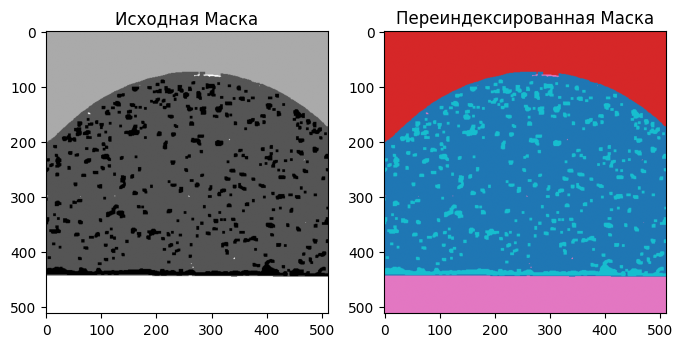

Результаты сравнения для Laws + SVM:
Точность (Accuracy): 68.9%
IoU по классам:
   Class 0: 0.775
   Class 1: 0.494
   Class 2: 0.000
   Class 3: 0.122


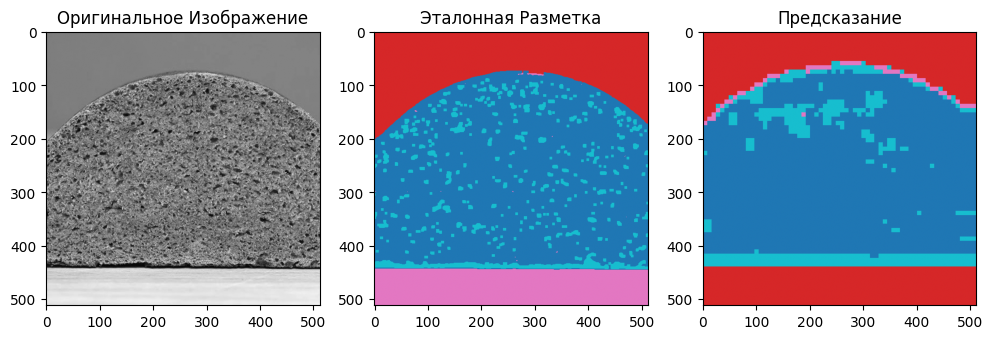

In [14]:
def remap_mask_labels(mask_in, max_colors=4):
    u_vals, u_counts = np.unique(mask_in, return_counts=True)
    sorted_idx = np.argsort(-u_counts)
    
    top_vals = u_vals[sorted_idx[:max_colors]]
    
    print(f"Цвета маски (топ-{max_colors}): {top_vals}")
    
    out_mask = np.zeros_like(mask_in)
    for new_idx, old_val in enumerate(top_vals):
        out_mask[mask_in == old_val] = new_idx
        
    return out_mask

GT_PATH = "bread_mask.png"
gt_raw = cv2.imread(GT_PATH, cv2.IMREAD_GRAYSCALE)

if gt_raw is not None:
    gt_clean = remap_mask_labels(gt_raw, max_colors=4)
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1); plt.imshow(gt_raw, cmap='gray'); plt.title("Исходная Маска")
    plt.subplot(1,2,2); plt.imshow(gt_clean, cmap='tab10'); plt.title("Переиндексированная Маска")
    plt.show()
else:
    print("Маска не найдена.")

def evaluate_results(true_mask, pred_mask, img_bg):
    if true_mask.shape != pred_mask.shape:
        pred_mask = cv2.resize(pred_mask, (true_mask.shape[1], true_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    map_dict = {0: 2, 1: 3, 2: 1, 3: 0}
    
    mapped_pred = np.zeros_like(pred_mask)
    for p_c, t_c in map_dict.items():
        mapped_pred[pred_mask == p_c] = t_c

    acc = accuracy_score(true_mask.flatten(), mapped_pred.flatten())
    n_classes = len(np.unique(gt_clean))
    ious = jaccard_score(true_mask.flatten(), mapped_pred.flatten(), average=None, labels=np.arange(n_classes))
    
    print(f"Точность (Accuracy): {acc:.1%}")
    print("IoU по классам:")
    for c_id, val in enumerate(ious):
        print(f"   Class {c_id}: {val:.3f}")

    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1); plt.imshow(img_bg, cmap='gray'); plt.title("Оригинальное Изображение")
    plt.subplot(1,3,2); plt.imshow(true_mask, cmap='tab10'); plt.title("Эталонная Разметка")
    plt.subplot(1,3,3); plt.imshow(mapped_pred, cmap='tab10'); plt.title("Предсказание")
    plt.show()

if 'Laws_SVM' in seg_results and gt_raw is not None:
    print("Результаты сравнения для Laws + SVM:")
    evaluate_results(gt_clean, seg_results['Laws_SVM'], orig_img_display)